<a href="https://colab.research.google.com/github/yikuizh/NEE_forecast/blob/master/EXP9_0507.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


'''
Link to Google Drive root
'''

!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/NEE'

/bin/bash: google-drive-ocamlfuse: command not found
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/NEE


In [ ]:
# no DT nt sw lw in this model

In [ ]:
'''
Import required packages
'''

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
from scipy.stats import pearsonr

import xgboost as xgb
from tensorflow import keras
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, LSTM, RepeatVector, Dropout, Input, Flatten,Concatenate
from keras.models import load_model
from keras.models import Model
from keras import optimizers
from tensorflow import optimizers
from xgboost import plot_importance
import matplotlib.pyplot as plt
import glob,os
import random
import os,shutil

In [ ]:
pip install xgboost==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
xgb.__version__

'1.7.2'

In [ ]:
# data preparation without lookback -- One to One prediction (o2o)
def data_prepare_o2o(datasetX,datasetY,scaler1, scaler2, shuffle):
    
    dataX, dataY = [], []
    scale_feature = scaler1.transform(datasetX)
    scale_target = scaler2.transform(datasetY.reshape(-1, 1))
    for i in range(len(datasetX)):
        feature = scale_feature[i]
        dataX.append(feature)
        target = scale_target[i]
        dataY.append(target)
        
    dataX, dataY = np.array(dataX), np.array(dataY)
    number_list = np.arange(0,len(dataX),1)
    random.shuffle(number_list) 
    dataX_new = []
    for index in number_list:
        dataX_new.append(dataX[index])
    dataY_new = []
    for index in number_list:
        dataY_new.append(dataY[index])

    if shuffle:
        return np.array(dataX_new), np.array(dataY_new)
    else:
        return np.array(dataX), np.array(dataY)

In [ ]:
'''
New Data load and merge
'''

dataset_new1 = pd.read_csv(r'/content/drive/My Drive/NEE/data/Yikui_16Nov22.csv'
                           ,index_col = 0)

#dataset_new2 = pd.read_csv(r'/content/drive/My Drive/NEE/data/ML_Yikui_new.csv'
 #                          ,index_col = 0)

#frame = [dataset_new1.drop(columns = 'Unnamed: 0.1'), dataset_new2]
#dataset_merged = pd.concat(frame)

all_sites = dataset_new1

sites = all_sites['Site'].unique()

result = pd.DataFrame(columns = sites, index = ['rmse_test', 'corr_test'])

In [ ]:
all_sites.

In [ ]:
result

In [ ]:
all_sites

In [ ]:
# dynamic features and static features #

#dynamic_dataset = all_sites.drop(columns=[ 'VegType', 'lat', 'lon', 'timeStamp', 'Year',
 #      'Month', 'classKoppen', 'soilType_ERA', 'Elavation'])

dynamic_dataset = all_sites.drop(columns=[ 'Veg', 'lat', 'lon', 'timeStamp', 'Year',
       'Month', 'soilType','Ele'])

static_dataset = all_sites.drop(columns=list(dynamic_dataset.columns.drop(['Site'])))
static_dataset = static_dataset.drop(columns=['timeStamp','Year'])

In [ ]:
static_dataset

In [ ]:
"""
Data engineering for static variables -- encode month; static variables -- class for encoding

"""
# month
# cos, sin
import numpy as np

static_dataset['month_sin'] = np.sin(static_dataset.Month*(2.*np.pi/12))
static_dataset['month_cos'] = np.cos(static_dataset.Month*(2.*np.pi/12))

## categorical variables -- categorical features: Koppen, VegType, SoilType

onehot_static_dataset = pd.get_dummies(static_dataset, columns=['VegType', 'classKoppen', 'soilType_ERA'])

onehot_static_dataset.drop(columns=['Month'])

In [ ]:
!pip install xgboost

In [ ]:
import xgboost

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl

In [ ]:
static_dataset

In [ ]:
# static feature analysis 
# 1. veg type

#dataset_merged['VegType'].unique()
veg_group = dataset_merged.groupby('VegType')


In [ ]:
dataset_merged['VegType'].unique()

array(['MF', 'GRA', 'SAV', 'WSA', 'EBF', 'WET', 'DBF', 'CRO', 'ENF',
       'OSH', 'CSH', 'DNF', 'SNO'], dtype=object)

In [ ]:
MF_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'MF']['NEE']
GRA_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'GRA']['NEE']
SAV_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'SAV']['NEE']
WSA_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'WSA']['NEE']
EBF_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'EBF']['NEE']
WET_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'WET']['NEE']
DBF_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'DBF']['NEE']
CRO_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'CRO']['NEE']
ENF_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'ENF']['NEE']
OSH_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'OSH']['NEE']
CSH_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'CSH']['NEE']
DNF_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'DNF']['NEE']
SNO_NEE = dataset_merged.loc[dataset_merged['VegType'] == 'SNO']['NEE']

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


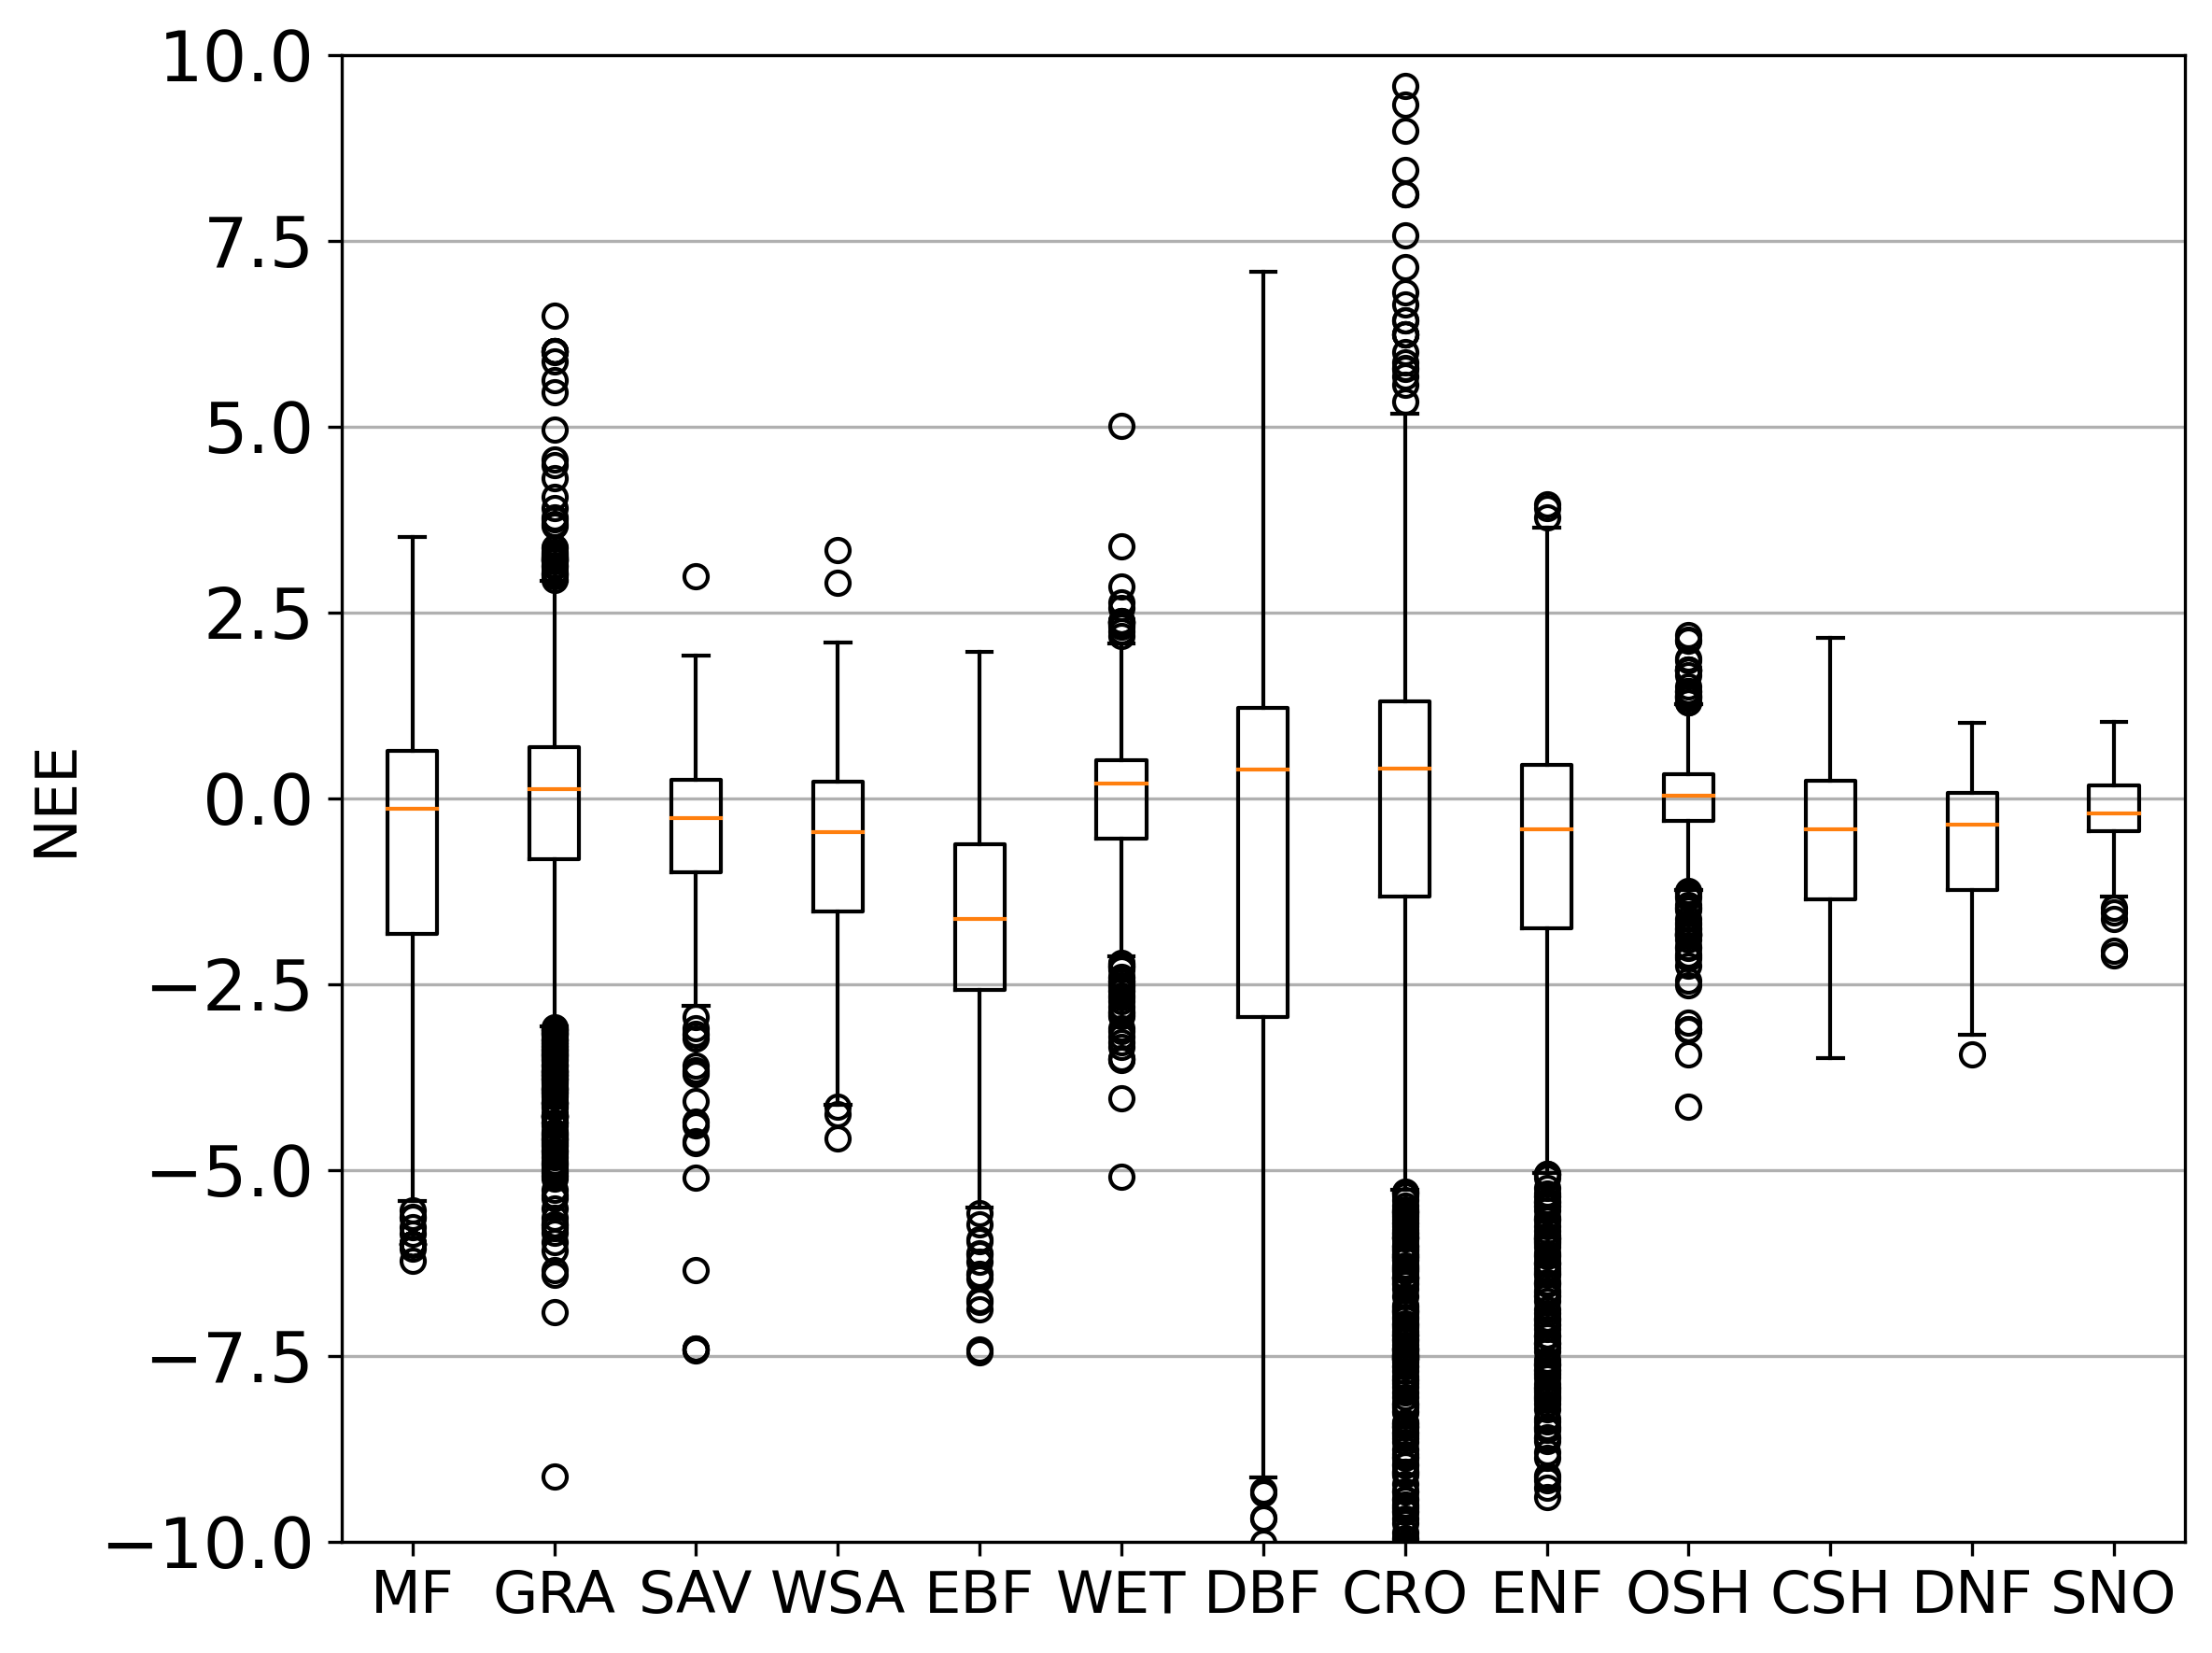

In [ ]:
# boxplot
import matplotlib
data = [MF_NEE.values, GRA_NEE.values,SAV_NEE.values ,WSA_NEE.values,EBF_NEE.values, WET_NEE.values ,DBF_NEE.values  ,CRO_NEE.values ,ENF_NEE.values ,OSH_NEE.values ,
       CSH_NEE.values ,DNF_NEE.values,SNO_NEE.values  ] # baseline


fig, ax = plt.subplots(figsize=(8,6),dpi = 300) 
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
ax.boxplot(data,widths=0.35)
ax.yaxis.grid(True)
plt.tick_params(labelsize=18)
ax.set_xticklabels(dataset_merged['VegType'].unique(),fontsize=15) # set x axis label

plt.ylim([-10,10])
ax.set_ylabel('NEE',fontsize=15)
#ax.set_xlabel('Catchment',fontsize=20)
#plt.plot([], c='tomato', label='Baseline LSTM') 
#plt.plot([], c='skyblue', label='Encoder-Decoder LSTM') 
#plt.legend(loc= 'lower left',fontsize=15 ) 
plt.tight_layout()
plt.show() 

In [ ]:
# 2. koppen

dataset_merged['classKoppen'].unique()

array(['BSk', 'Cfb', 'BWh', 'Aw', 'Cfa', 'BSh', 'Csa', 'Am', 'Dfb', 'Dfc',
       'Dwa', 'Dwb', 'ET', nan, 'Csb', 'Af', 'Dfd', 'Dfa', 'Dsb', 'Dsc',
       'Cwa'], dtype=object)

In [ ]:
BSk_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'BSk']['NEE']
Cfb_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Cfb']['NEE']
BWh_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'BWh']['NEE']
Aw_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Aw']['NEE']
Cfa_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Cfa']['NEE']
BSh_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'BSh']['NEE']
Csa_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Csa']['NEE']
Am_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Am']['NEE']
Dfb_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dfb']['NEE']
Dfc_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dfc']['NEE']
Dwa_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dwa']['NEE']
Dwb_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dwb']['NEE']
ET_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'ET']['NEE']
Csb_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Csb']['NEE']
Af_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Af']['NEE']
Dfd_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dfd']['NEE']
Dsb_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dsb']['NEE']
Dsc_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Dsc']['NEE']
Cwa_NEE = dataset_merged.loc[dataset_merged['classKoppen'] == 'Cwa']['NEE']


In [ ]:
# boxplot
import matplotlib
data = [BSk_NEE.values, Cfb_NEE.values,BWh_NEE.values ,Aw_NEE.values,Cfa_NEE.values, BSh_NEE.values ,Csa_NEE.values  ,Am_NEE.values ,Dfb_NEE.values ,Dfc_NEE.values ,
       Dwa_NEE.values ,Dwb_NEE.values,ET_NEE.values, Csb_NEE,  Af_NEE,Dfd_NEE, Dsb_NEE, Dsc_NEE, Cwa_NEE ] # baseline


fig, ax = plt.subplots(figsize=(8,6),dpi = 300) 
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
ax.boxplot(data,widths=0.35)
ax.yaxis.grid(True)
plt.tick_params(labelsize=18)
ax.set_xticklabels(dataset_merged['classKoppen'].unique(),fontsize=15) # set x axis label

plt.ylim([-10,10])
ax.set_ylabel('NEE',fontsize=15)
#ax.set_xlabel('Catchment',fontsize=20)
#plt.plot([], c='tomato', label='Baseline LSTM') 
#plt.plot([], c='skyblue', label='Encoder-Decoder LSTM') 
#plt.legend(loc= 'lower left',fontsize=15 ) 
plt.tight_layout()
plt.show() 

In [ ]:
dataset_merged['classKoppen'].unique()

array(['BSk', 'Cfb', 'BWh', 'Aw', 'Cfa', 'BSh', 'Csa', 'Am', 'Dfb', 'Dfc',
       'Dwa', 'Dwb', 'ET', nan, 'Csb', 'Af', 'Dfd', 'Dfa', 'Dsb', 'Dsc',
       'Cwa'], dtype=object)

In [ ]:
np.isnan(dataset_merged['classKoppen'].unique())

In [ ]:
dataset_merged['classKoppen'].unique()

array(['BSk', 'Cfb', 'BWh', 'Aw', 'Cfa', 'BSh', 'Csa', 'Am', 'Dfb', 'Dfc',
       'Dwa', 'Dwb', 'ET', nan, 'Csb', 'Af', 'Dfd', 'Dfa', 'Dsb', 'Dsc',
       'Cwa'], dtype=object)

In [ ]:
# 3. soil type

dataset_merged['soilType'].unique()[0]

4

In [ ]:
dataset_merged['soilType'] == '4'

0       False
1       False
2       False
3       False
4       False
        ...  
3782    False
3783    False
3784    False
3785    False
3786    False
Name: soilType, Length: 15188, dtype: bool

In [ ]:
dataset_merged.loc[dataset_merged['soilType'] == 4]

,Site,VegType,lat,lon,timeStamp,Year,Month,ST,TD,TN,...,SWC_ERA,ST_ERA,PRE_ERA,soilType,high_vegType,low_vegType,high_vegCover,low_vegCover,Elavation,NEE


In [ ]:
NEE4 = dataset_merged.loc[dataset_merged['soilType'] == 4]['NEE']
NEE2 = dataset_merged.loc[dataset_merged['soilType'] == 2]['NEE']
NEE1 = dataset_merged.loc[dataset_merged['soilType'] == 1]['NEE']
NEE3 = dataset_merged.loc[dataset_merged['soilType'] == 3]['NEE']
NEE0 = dataset_merged.loc[dataset_merged['soilType'] == 0]['NEE']
NEE6 = dataset_merged.loc[dataset_merged['soilType'] == 6]['NEE']


In [ ]:
NEE4

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


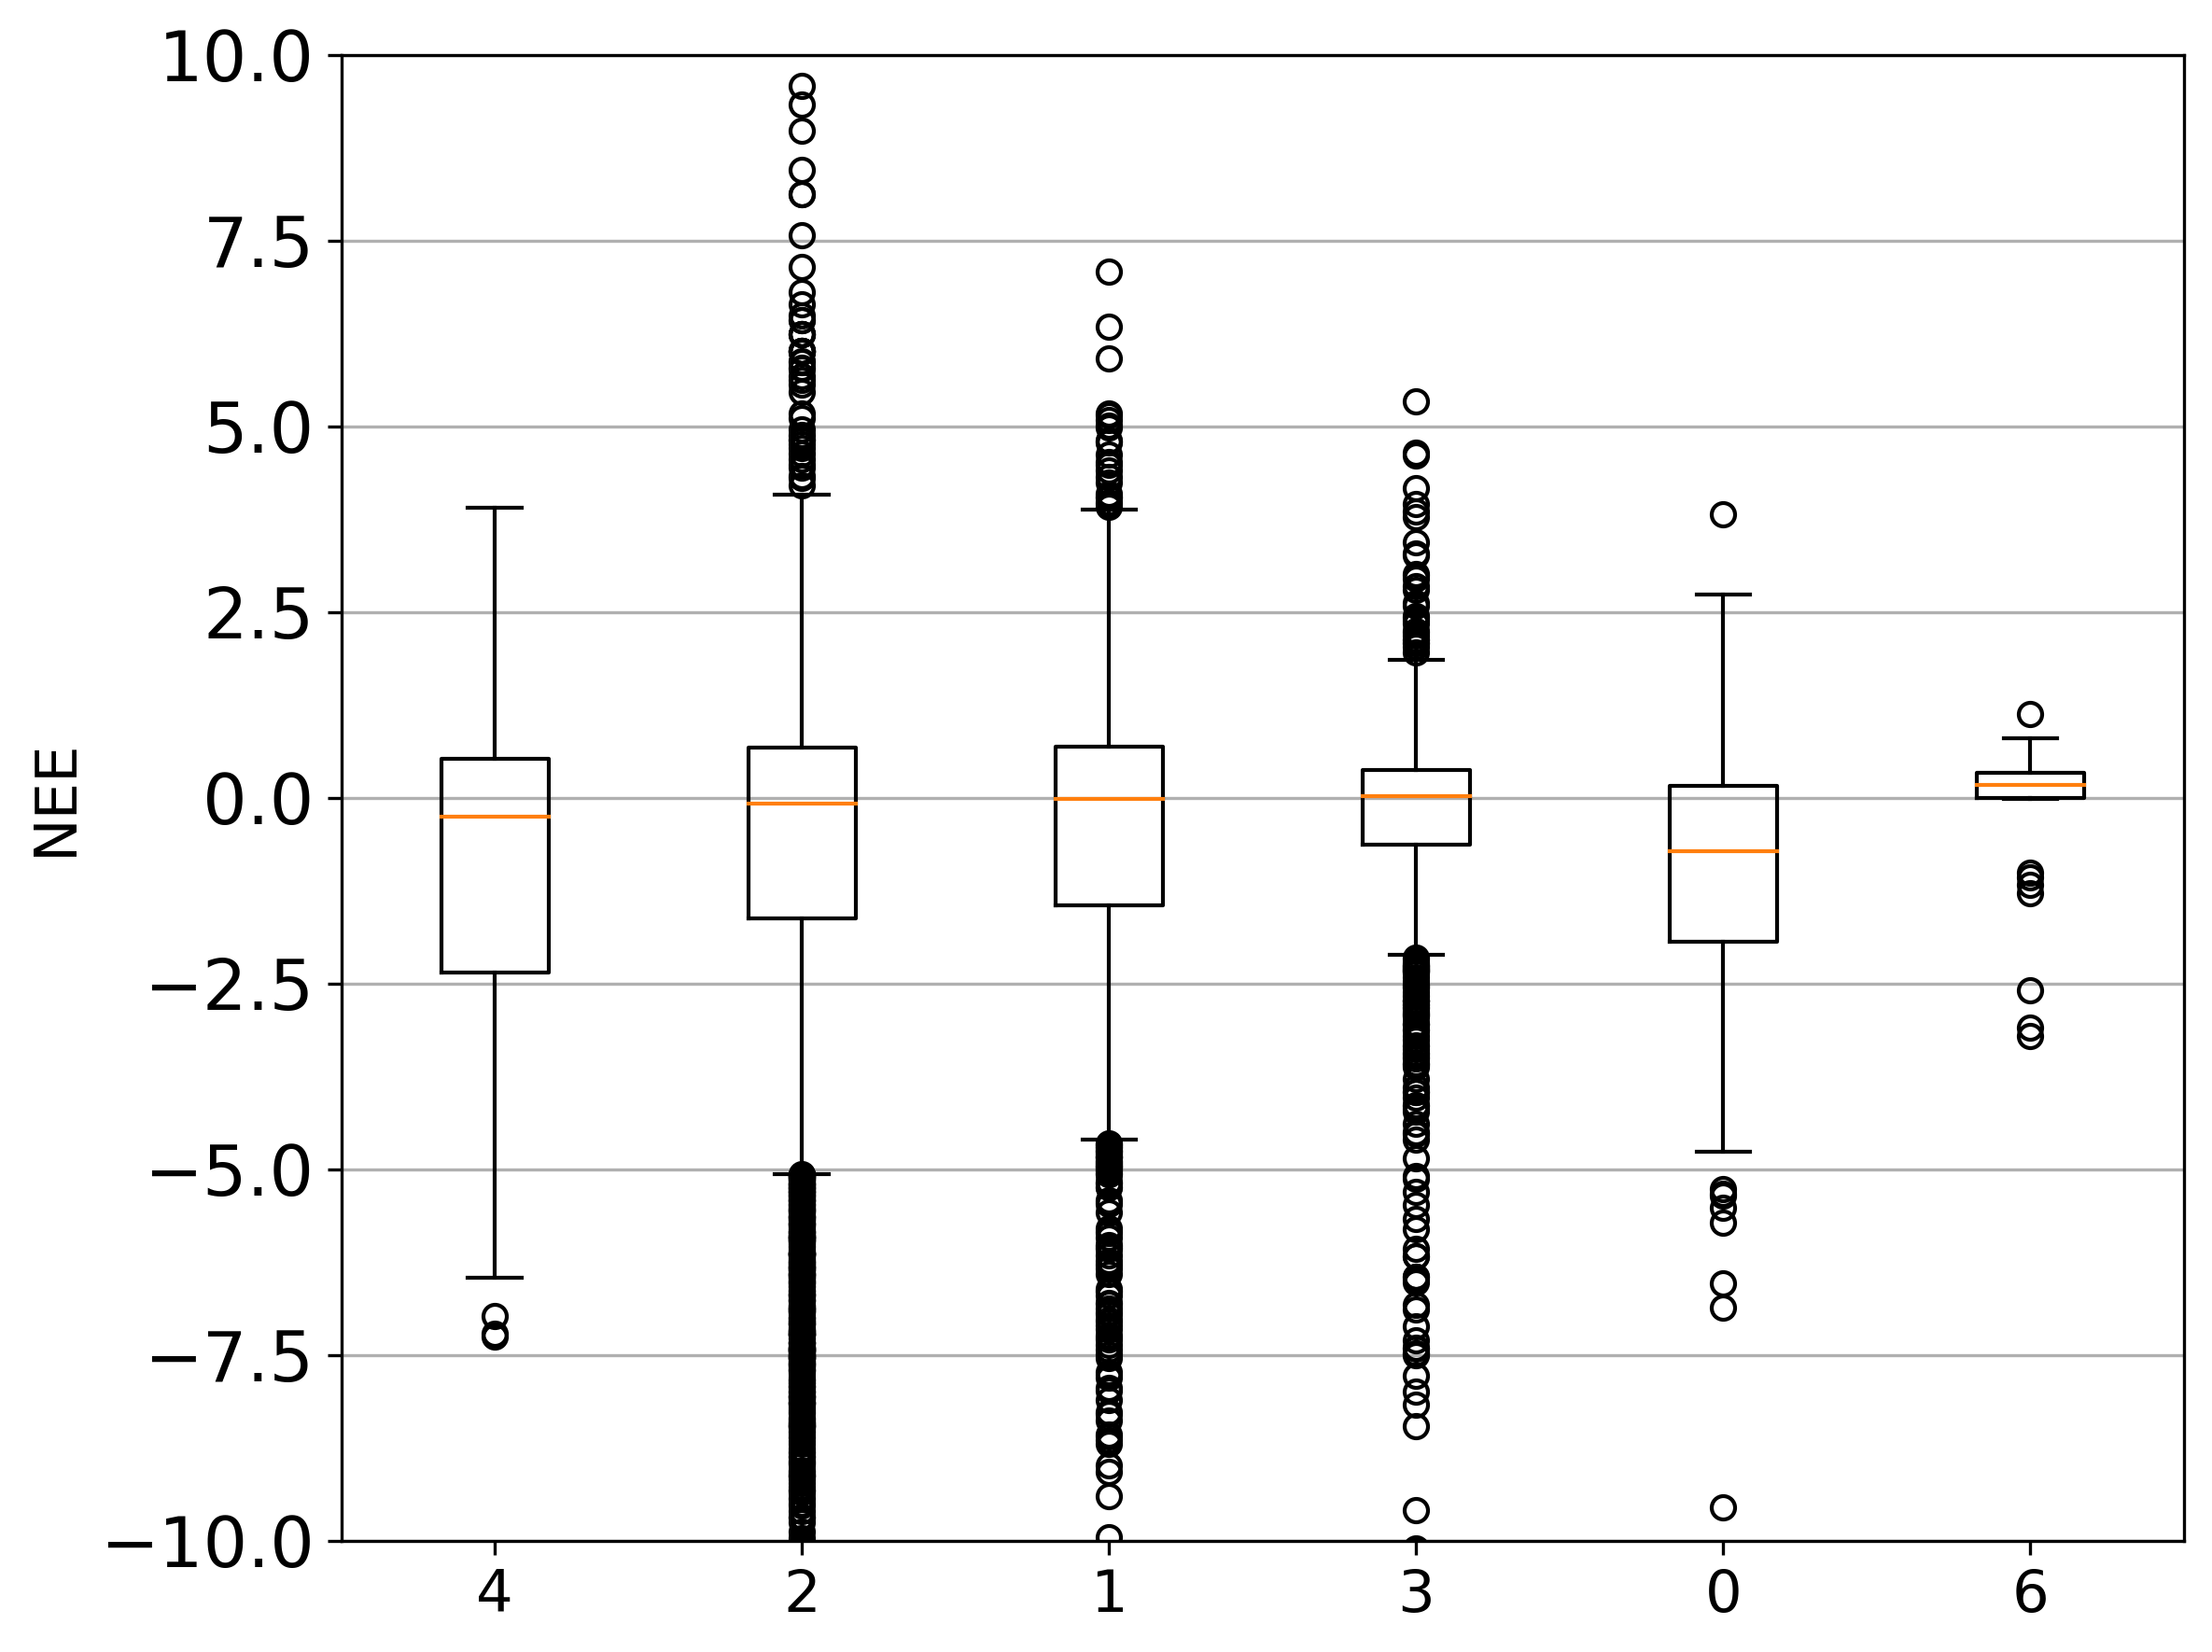

In [ ]:
# boxplot
import matplotlib
data = [NEE4.values, NEE2.values,NEE1.values ,NEE3.values,NEE0.values, NEE6.values ] # baseline


fig, ax = plt.subplots(figsize=(8,6),dpi = 300) 
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
ax.boxplot(data,widths=0.35)
ax.yaxis.grid(True)
plt.tick_params(labelsize=18)
ax.set_xticklabels(dataset_merged['soilType'].unique(),fontsize=15) # set x axis label

plt.ylim([-10,10])
ax.set_ylabel('NEE',fontsize=15)
#ax.set_xlabel('Catchment',fontsize=20)
#plt.plot([], c='tomato', label='Baseline LSTM') 
#plt.plot([], c='skyblue', label='Encoder-Decoder LSTM') 
#plt.legend(loc= 'lower left',fontsize=15 ) 
plt.tight_layout()
plt.show() 

In [ ]:
# 4. lat/lon

def rotation(data):
  '''
  # most frequently used degrees are 30,45,60
  input: dataframe containing Latitude(x) and Longitude(y)
  '''
  rot_45_x = (0.707 * data['x']) + (0.707 * data['y'])
  rot_45_y = (0.707 * data['y']) + (0.707 * data['x'])
  rot_30_x = (0.866 * data['x']) + (0.5 * data['y'])
  rot_30_y = (0.866 * data['y']) + (0.5 * data['x'])
  return rot_45_x, rot_45_y, rot_30_x, rot_30_y

In [ ]:
# dynamic feature analysis

In [ ]:
dynamic_dataset.columns

Index(['Site', 'ST_FN', 'P_FN', 'H_FN', 'LE_FN', 'VPD_FN', 'WS_FN', 'SW_FN',
       'LW_FN', 'NEE_FN', 'SWC_ERA', 'P_ERA', 'AT_2m_ERA', 'DPT_2m_ERA',
       'lai_hv_ERA', 'lai_lv_ERA', 'ST_ERA', 'SWC_ERA.1', 'H_ERA', 'LE_ERA',
       'VPD_ERA', 'WS_ERA'],
      dtype='object')

In [ ]:
# correlation
temp = dynamic_dataset['DPT_2m_ERA',
       'lai_hv_ERA', 'lai_lv_ERA', 'ST_ERA', 'SWC_ERA.1', 'H_ERA', 'LE_ERA',
       'VPD_ERA', 'WS_ERA']

In [ ]:
import seaborn as sns
dynamic_corr = dynamic_dataset.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(dynamic_corr,cmap='coolwarm', square = True, annot = True, vmax=0.5, vmin=-0.5, center=0)

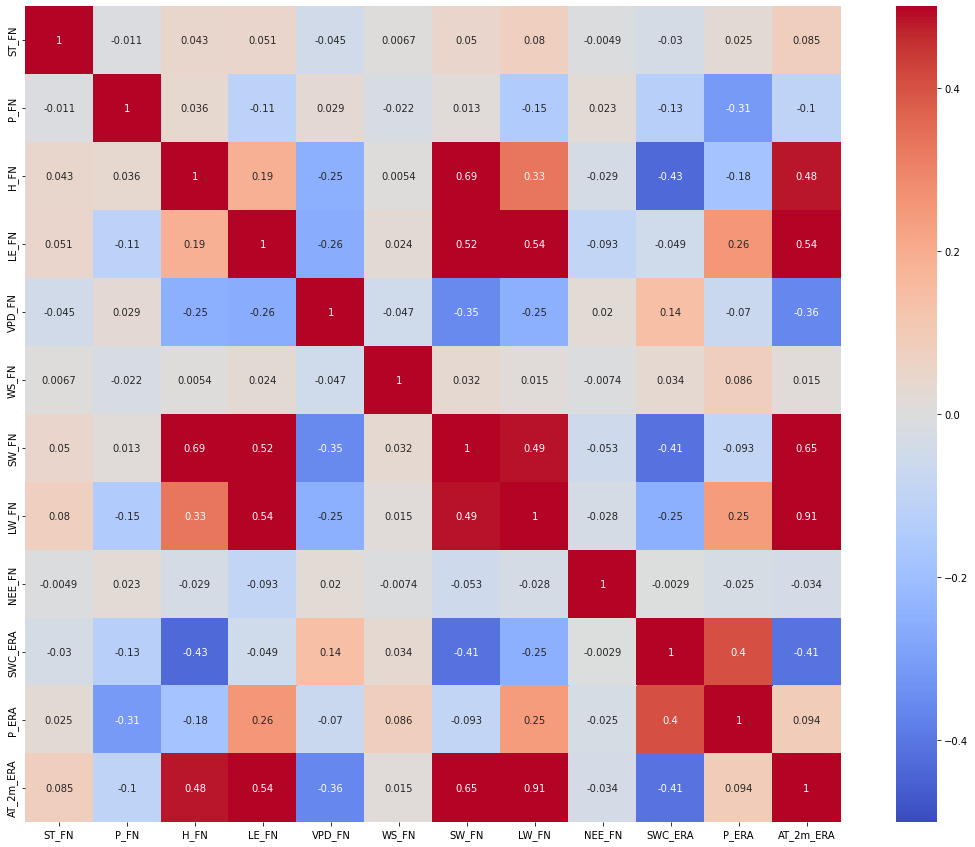

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(dynamic_corr,cmap='coolwarm', square = True, annot = True, vmax=0.5, vmin=-0.5, center=0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(dynamic_corr,cmap='coolwarm', square = True, annot = True, vmax=0.5, vmin=-0.5, center=0)

In [ ]:
dataset_merged['Site'].unique()

In [ ]:
# month
fig, ax = plt.subplots(figsize=(12,9))
dataset_merged.loc[dataset_merged['Site'] == dataset_merged['Site'].unique()[11]]['NEE'].plot()


In [ ]:
dataset_merged.loc[dataset_merged['Site'] ==dataset_merged['Site'].unique()[1]]['Month']

In [ ]:

dataset_merged.loc[dataset_merged['Site'] ==dataset_merged['Site'].unique()[1]]['Month']

In [ ]:
dataset_merged.loc[dataset_merged['Site'] ==dataset_merged['Site'].unique()[5]]['Month'].plot()

In [ ]:

month_data = pd.DataFrame(columns=['Month', 'NEE'])


In [ ]:
month_data

In [ ]:
month_data['Month'] = dataset_merged.loc[dataset_merged['Site'] ==dataset_merged['Site'].unique()[1]]['Month']
month_data['NEE'] = dataset_merged.loc[dataset_merged['Site'] == dataset_merged['Site'].unique()[1]]['NEE']

In [ ]:
month_corr = month_data.corr()

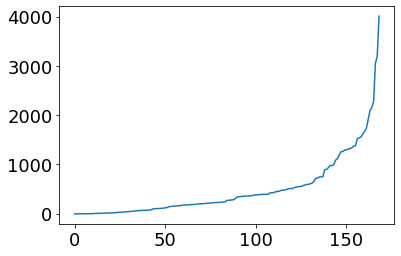

In [ ]:
plt.plot(dataset_merged.groupby('Elavation').mean()['NEE'].index)

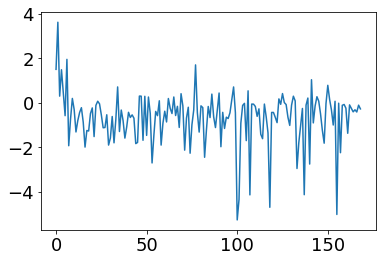

In [ ]:
plt.plot(dataset_merged.groupby('Elavation').mean()['NEE'].values)

In [ ]:
new_dataset = dataset_merged.drop(columns=['classKoppen', 'soilType', 'high_vegType', 'low_vegType', 'timeStamp', 'Year',
       'high_vegCover', 'low_vegCover','TN','LW'])

In [ ]:
new_dataset

In [ ]:
# 11.27
new_dataset = all_sites.drop(columns=['Veg',  'timeStamp', 'Year','soilType'])

In [ ]:
# 01.21
new_dataset = all_sites.drop(columns=['Veg',  'timeStamp', 'Year','soilType', 'TD', 'TN', 'SW', 'LW'])

In [ ]:
all_sites.columns

Index(['Site', 'Veg', 'lat', 'lon', 'timeStamp', 'Year', 'Month', 'ST', 'TD',
       'TN', 'P', 'H', 'LE', 'VPD', 'WS', 'SW', 'LW', 'NEE', 'lai_hv_ERA',
       'lai_lv_ERA', 'SWC_ERA', 'soilType', 'PH', 'NIT', 'SOC', 'Ele'],
      dtype='object')

In [ ]:
new_dataset

In [ ]:
# XGBOOST REGRESSION
# data preprocess -- static
def rotation(data):
  '''
  # most frequently used degrees are 30,45,60
  input: dataframe containing Latitude(x) and Longitude(y)
  '''
  rot_45_x = (0.707 * data['lat']) + (0.707 * data['lon'])
  rot_45_y = (0.707 * data['lon']) + (0.707 * data['lat'])
  rot_30_x = (0.866 * data['lat']) + (0.5 * data['lon'])
  rot_30_y = (0.866 * data['lon']) + (0.5 * data['lat'])
  return rot_45_x, rot_45_y, rot_30_x, rot_30_y


In [ ]:
new_dataset['rot_45_x'],new_dataset['rot_45_y'],new_dataset['rot_30_x'], new_dataset['rot_30_y']=rotation(new_dataset)
onehot_dataset = new_dataset
sites =all_sites['Site'].unique()
dataset_merged = all_sites

In [ ]:
# we do not use veg type this time
onehot_dataset = pd.get_dummies(new_dataset, columns=['VegType'])

In [ ]:
# XGBOOST - TRAINING # 

# train and test split on all sites
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle = True,random_state = 1) # n_splites can be changed based on different folds required; 
train_index_list = []
test_index_list = []
# train_index as gauged location for training, test_index as ungauged catchments for testing
for train_index, test_index in kf.split(sites):
    train_index_list.append(train_index)
    test_index_list.append(test_index)



In [ ]:
feature_important = regressor2.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

fi = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
fi.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
onehot_dataset.columns

Index(['Site', 'lat', 'lon', 'Month', 'ST', 'P', 'H', 'LE', 'VPD', 'WS', 'NEE',
       'lai_hv_ERA', 'lai_lv_ERA', 'SWC_ERA', 'PH', 'NIT', 'SOC', 'Ele',
       'rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y'],
      dtype='object')

1
Train Score: 0.62 RMSE
Test Score: 1.59 RMSE
Train corr: 0.96 corr
Test corr: 0.77 corr
2
Train Score: 0.56 RMSE
Test Score: 1.27 RMSE
Train corr: 0.97 corr
Test corr: 0.75 corr
3
Train Score: 0.59 RMSE
Test Score: 1.73 RMSE
Train corr: 0.97 corr
Test corr: 0.42 corr
4
Train Score: 0.56 RMSE
Test Score: 1.42 RMSE
Train corr: 0.97 corr
Test corr: 0.60 corr
5
Train Score: 0.58 RMSE
Test Score: 1.84 RMSE
Train corr: 0.97 corr
Test corr: 0.79 corr
6
Train Score: 0.58 RMSE
Test Score: 1.56 RMSE
Train corr: 0.97 corr
Test corr: 0.72 corr
7
Train Score: 0.65 RMSE
Test Score: 1.95 RMSE
Train corr: 0.96 corr
Test corr: 0.58 corr
8
Train Score: 0.59 RMSE
Test Score: 1.66 RMSE
Train corr: 0.97 corr
Test corr: 0.67 corr
9
Train Score: 0.54 RMSE
Test Score: 1.69 RMSE
Train corr: 0.97 corr
Test corr: 0.56 corr
10
Train Score: 0.55 RMSE
Test Score: 2.12 RMSE
Train corr: 0.97 corr
Test corr: 0.66 corr


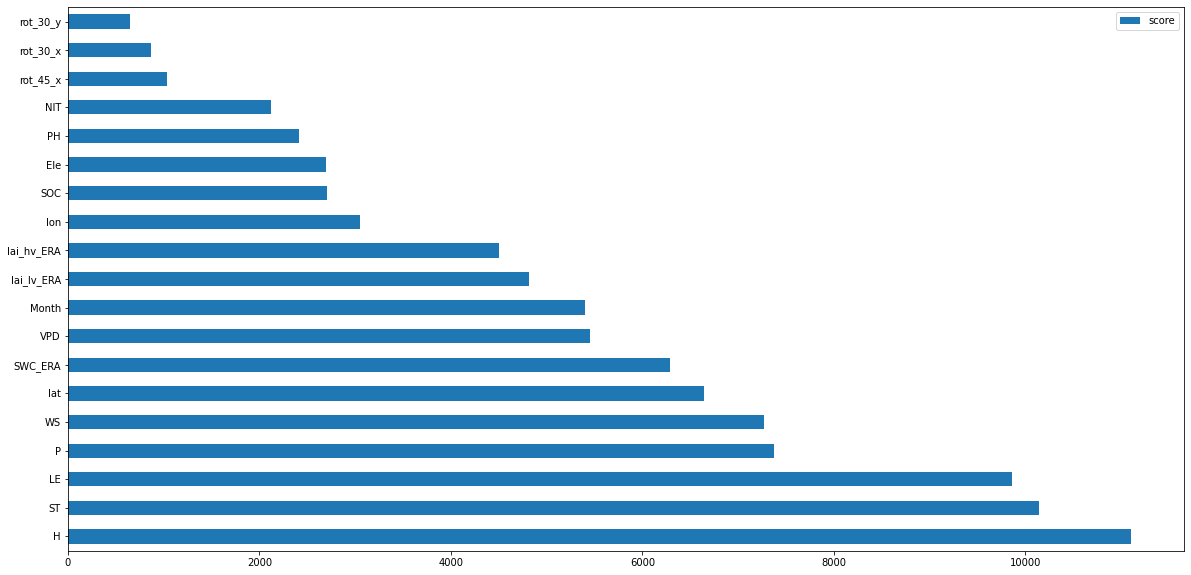

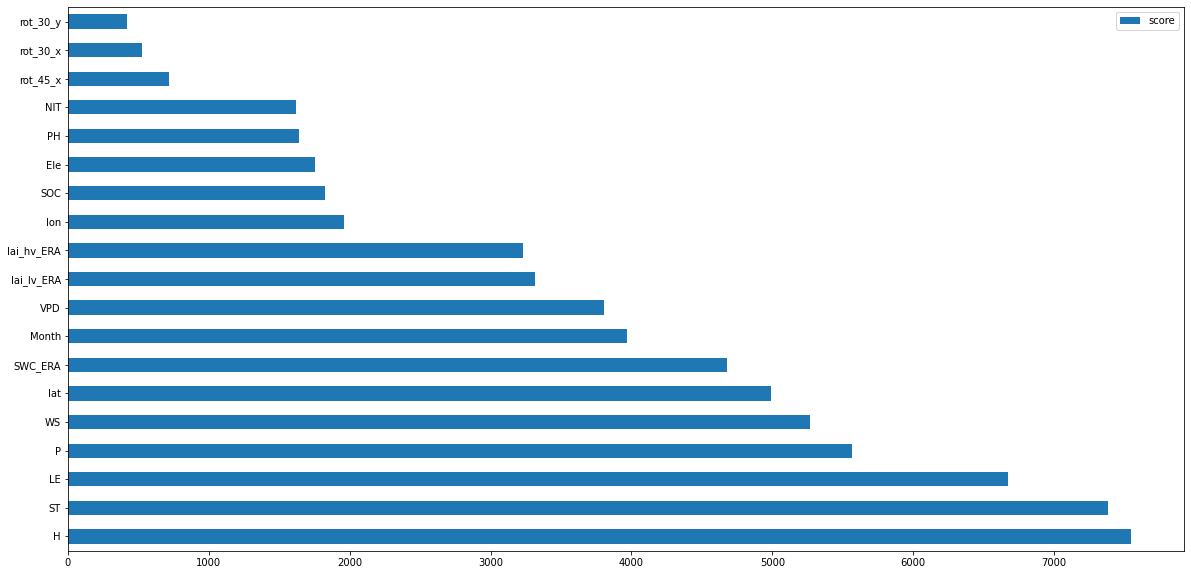

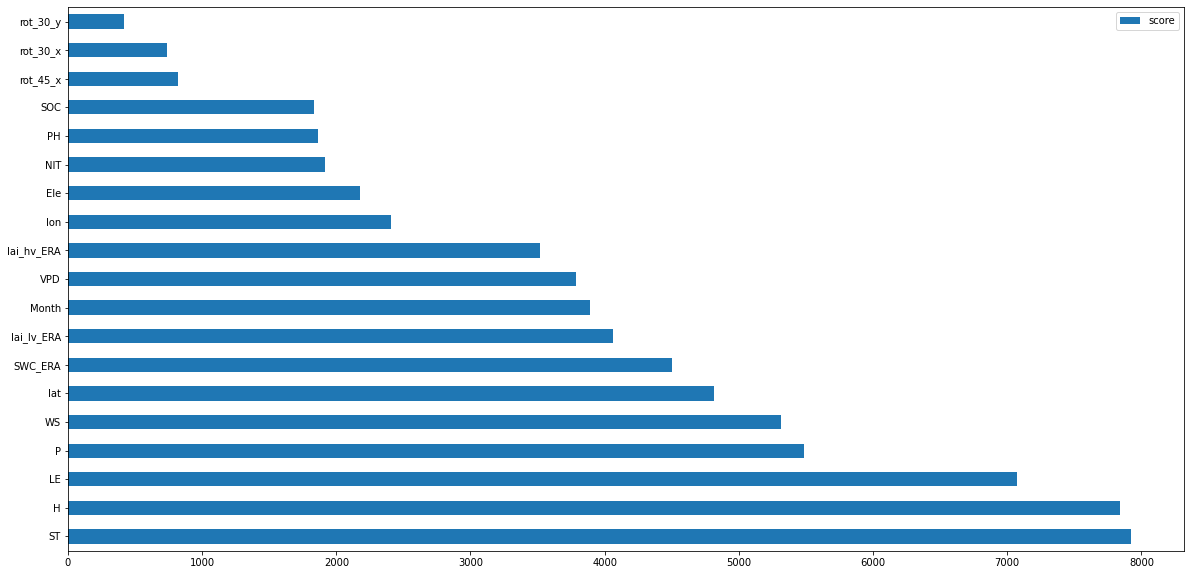

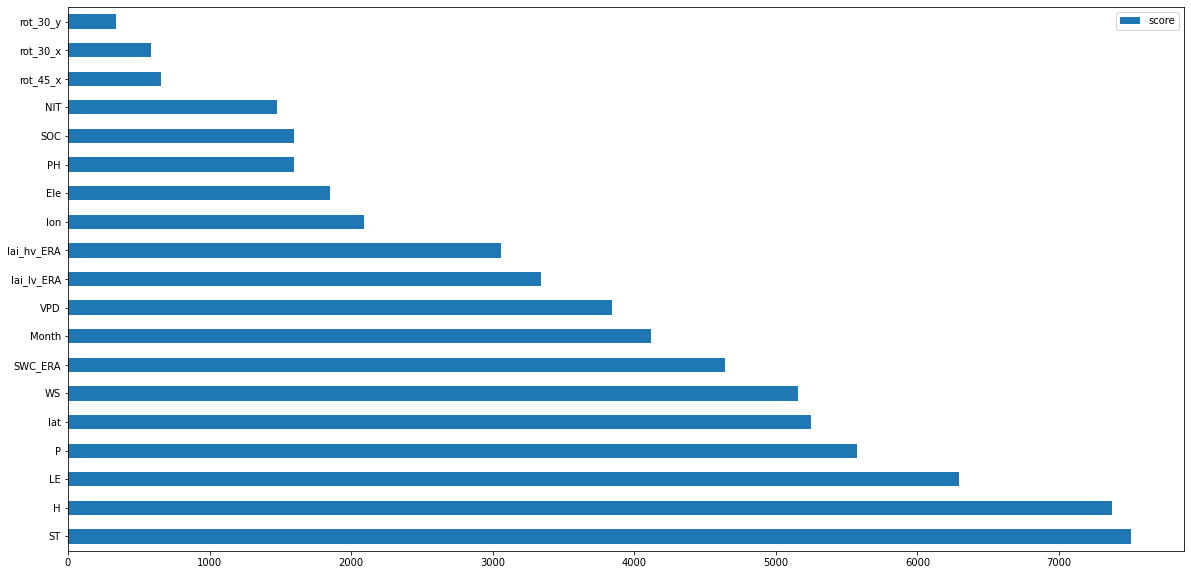

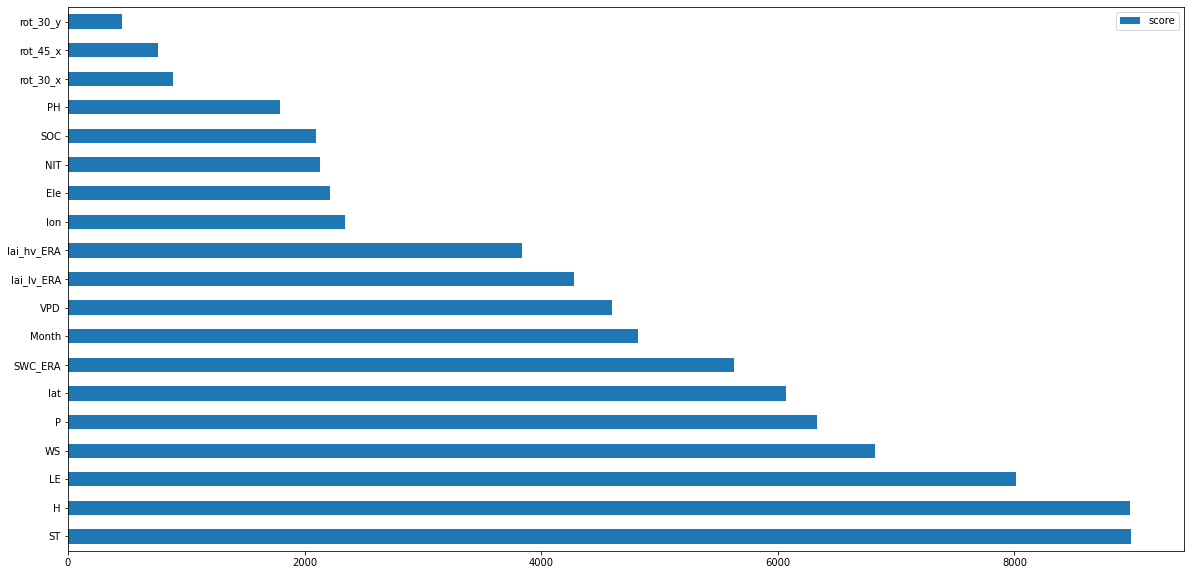

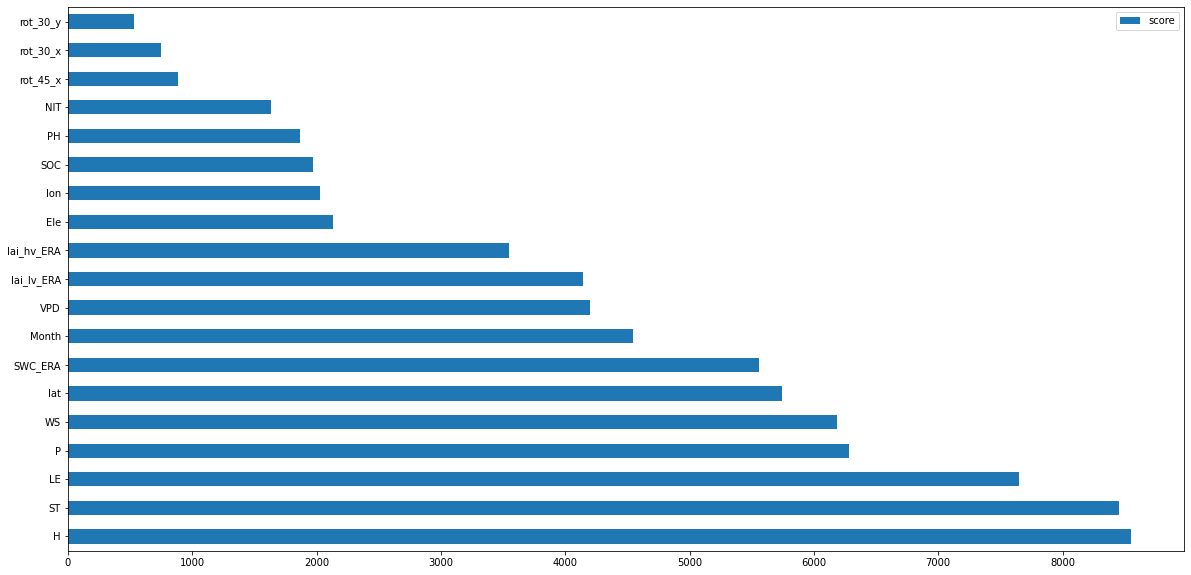

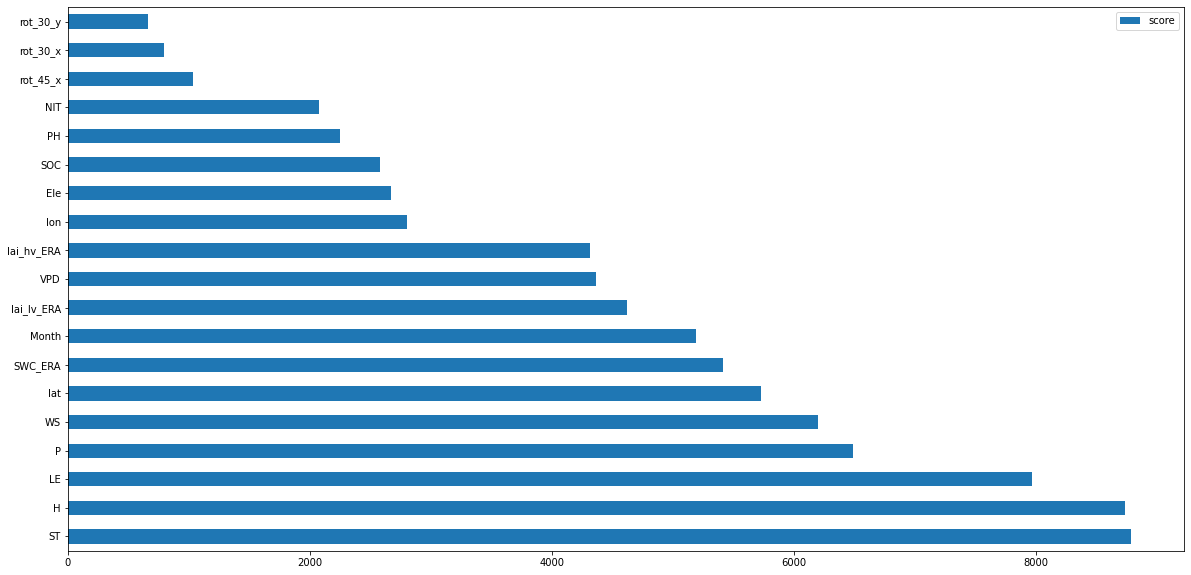

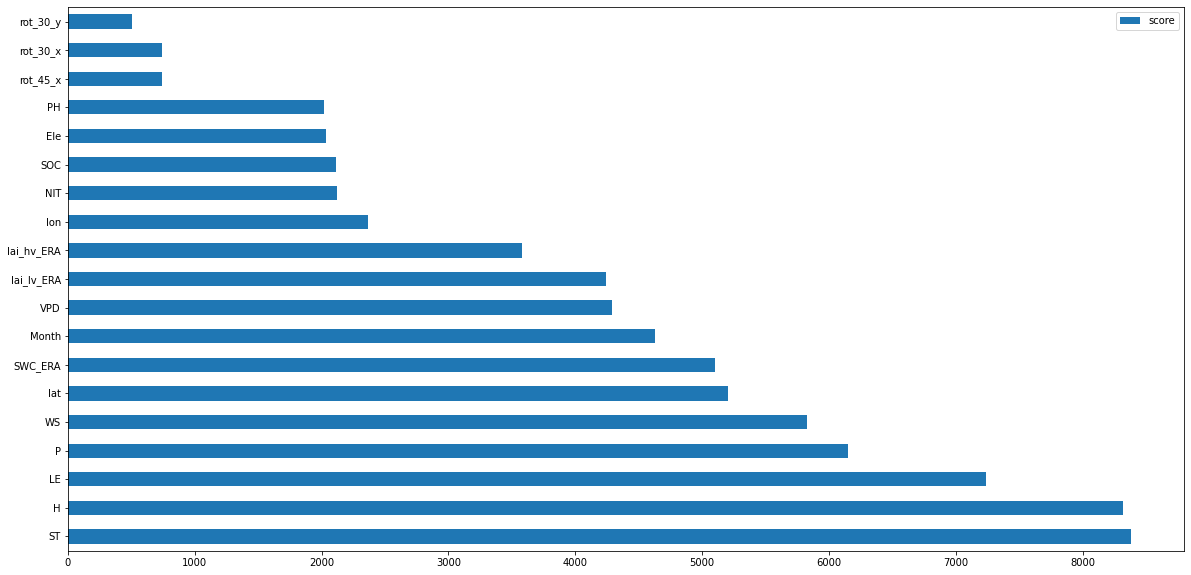

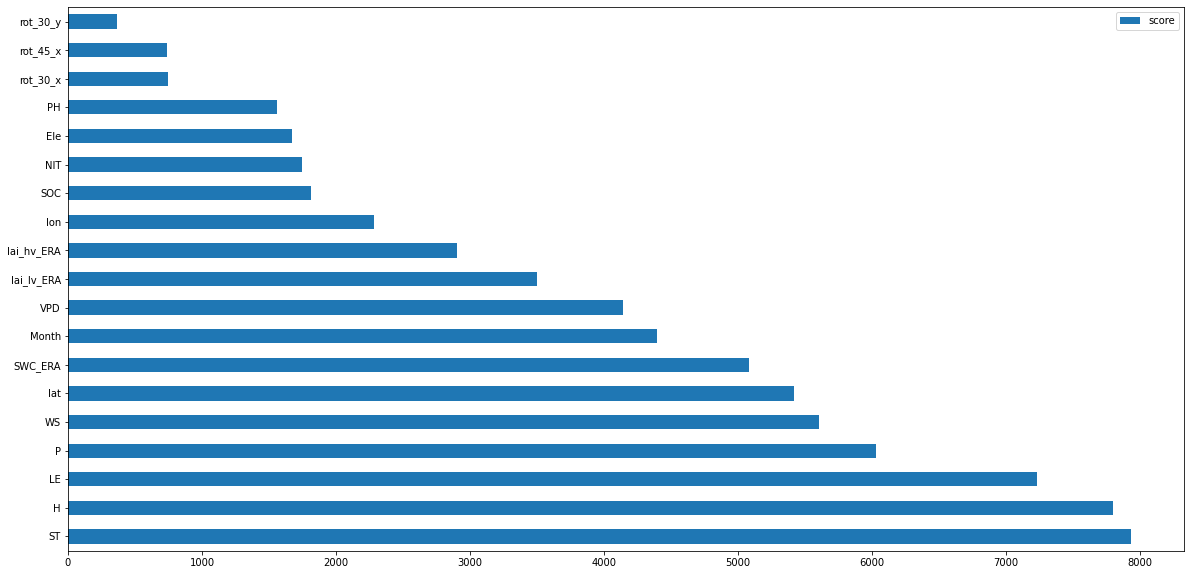

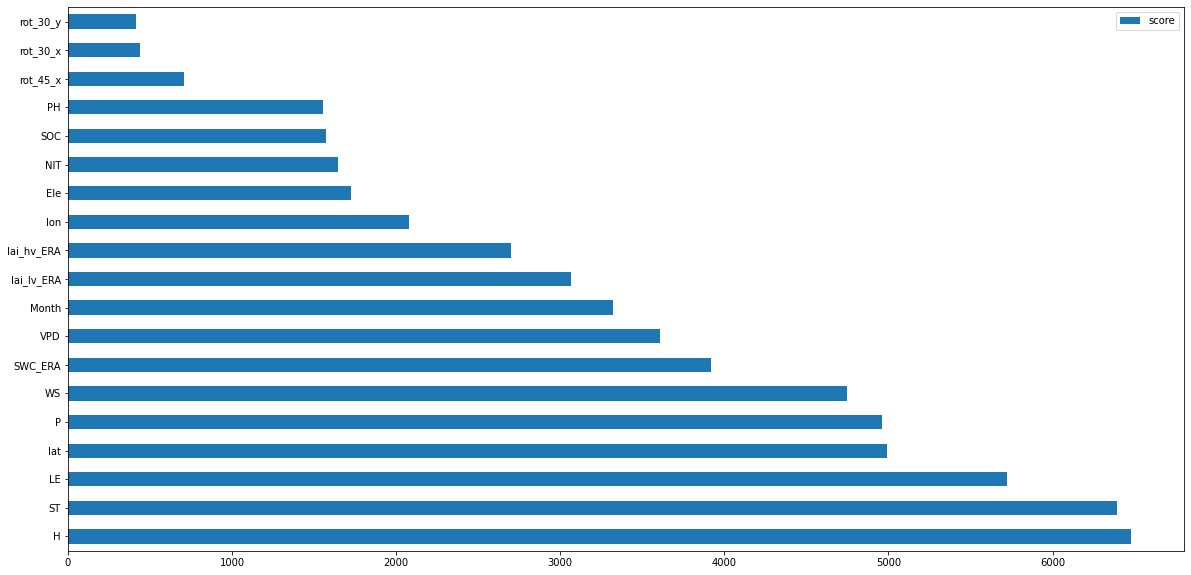

In [ ]:
for i in range(len(train_index_list)):
    num_ite = i + 1 # count the number of folder
    print (num_ite)

    train_sites = onehot_dataset.Site.unique()[train_index_list[i]]
    trainX_dataset = onehot_dataset[dataset_merged.Site.isin(train_sites)].drop(columns=['Site','NEE']) # xgboost can read DF file directly
    trainY_dataset = onehot_dataset[dataset_merged.Site.isin(train_sites)]['NEE']


    test_sites = onehot_dataset.Site.unique()[test_index_list[i]]
    testX_dataset = onehot_dataset[dataset_merged.Site.isin(test_sites)].drop(columns=['Site','NEE'])
    testY_dataset = onehot_dataset[dataset_merged.Site.isin(test_sites)]['NEE']

    # train and test dataset

    regressor=xgb.XGBRegressor(eval_metric='rmse')

    #=========================================================================
    # exhaustively search for the optimal hyperparameters
    #=========================================================================
    from sklearn.model_selection import GridSearchCV
    # set up our search grid
    param_grid = {
                  "n_estimators": [450, 500,550],
                  "learning_rate": [0.01,0.02,0.015]}

    # try out every combination of the above values
    search = GridSearchCV(regressor, param_grid, cv=4).fit(trainX_dataset, trainY_dataset)

    #print("The best hyperparameters are ",search.best_params_)
    regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = 8,
                           eval_metric='rmse')

    regressor.fit(trainX_dataset, trainY_dataset)
    regressor.save_model('/content/drive/My Drive/NEE/XGBoost/0121/train_model/xgb_%s.json' % num_ite)

    feature_important = regressor.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    fi = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    fi.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
    fi.to_csv(r'/content/drive/My Drive/NEE/XGBoost/0121/train_model/fi_%s.csv' % num_ite)

    #=========================================================================
    # To use early_stopping_rounds: 
    # "Validation metric needs to improve at least once in every 
    # early_stopping_rounds round(s) to continue training."
    #=========================================================================
    # first perform a test/train split 
    #from sklearn.model_selection import train_test_split

    #X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
    #regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

    #=========================================================================
    # use the model to predict the prices for the test data
    #=========================================================================
    
    train_predictions = regressor.predict(trainX_dataset)
    predictions = regressor.predict(testX_dataset)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_dataset.values,train_predictions))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_dataset.values,predictions))
    print('Test Score: %.2f RMSE' % (testScore))
    # calculate correlation score
    corr_train, _ = pearsonr(trainY_dataset.values,train_predictions)
    print('Train corr: %.2f corr' % (corr_train))
    corr_test, _ = pearsonr(testY_dataset.values,predictions)
    print('Test corr: %.2f corr' % (corr_test))

    ### for individual site ###
    for k in range(len(test_sites)):
        # make predictions
        #test_sites = onehot_dataset.Site.unique()[test_index_list[0]]
        testX_dataset = onehot_dataset[onehot_dataset['Site'] == test_sites[k]].drop(columns=['Site','NEE'])
        testY_dataset = onehot_dataset[onehot_dataset['Site'] == test_sites[k]]['NEE']

        testPredict = regressor.predict(testX_dataset)

        # calculate root mean squared error

        testScore = math.sqrt(mean_squared_error(testY_dataset.values, testPredict))
        #print('Test Score: %.2f RMSE' % (testScore))
        # calculate correlation score
        corr_test, _ = pearsonr(testY_dataset.values, testPredict)
        result[test_sites[k]] = [testScore,corr_test]
        #print ("The prediction results of", test_sites[k], testScore, corr_test)

In [ ]:
sites = ['BE-Bra', 'CA-TP3',  'DE-Hai']
site = test_sites[1]

In [ ]:
# test results for plotting
from sklearn.metrics import r2_score 
# select 3 measurement points from different regions
testX_dataset = onehot_dataset[onehot_dataset['Site'] == site].drop(columns=['Site','NEE'])
testY_dataset = onehot_dataset[onehot_dataset['Site'] == site]['NEE']

testPredict = regressor.predict(testX_dataset)

# calculate root mean squared error

testScore = math.sqrt(mean_squared_error(testY_dataset.values, testPredict))
#print('Test Score: %.2f RMSE' % (testScore))
# calculate correlation score
corr_test, _ = pearsonr(testY_dataset.values, testPredict)

obs1 = testY_dataset.values
prediction1 = testPredict
rmse1 = testScore
corr1 = corr_test
nse1 = r2_score(np.array(obs1).flatten(), np.array(prediction1).flatten())

In [ ]:
nse1

0.6030915165373247

In [ ]:
# single event
import matplotlib
fig = plt.figure(figsize=(9,6)) 
fig=plt.gcf()
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 12

# plot one event
fig, ax = plt.subplots(figsize=(9,6),dpi=300)
#fig=plt.gcf()step
step = np.arange(len(np.array(obs1).flatten()))
l1 = ax.plot(np.array(obs1).flatten(), color = '#ED7D31') 
l2 = ax.plot(np.array(prediction1).flatten(), '--', color = '#ED7D31') 

#l3 = ax.plot(np.array(predictions).flatten(), color = '#0cdc73') 
#l4 = ax.plot(np.array(y).flatten(),color = 'k') 
#l5 = ax.plot(np.array(predictions2).flatten(), color = '#ED7D31')
#l6 = ax.plot(np.array(predictions).flatten(), color = '#0cdc73') 

#ax_sub = ax.twinx()
#l4 = ax_sub.bar(step,data_2['prcp_obs'][24:-1].values,width=0.8, alpha = 0.6)
#l5 = ax_sub.bar(step,data_2['Precip_w'][24:-1].values,width=0.8, alpha = 0.6)
#l6 = ax_sub.bar(step,data_2['Precip_e'][24:-1].values,width=0.8, alpha = 0.6)
#l4 = ax_sub.plot(data_2['precip'][24:-1].values) 
#l5 = ax_sub.plot(data_2['Precip_w'][24:-1].values) # edlstm
#l6 = ax_sub.plot(data_2['Precip_e'][24:-1].values) # baseline lstm
#ln = l1 + l2 +l3 + [l4] + [l5] + [l6]
ln = l1 + l2
# invert
#ax_sub.invert_yaxis()
ax.set_ylabel('NEE/µmolCO2 m-2 s-1')
#ax_sub.set_ylabel('m3/s')
#ax_sub.set_ylim(1.2*np.max(data_2['precip'][24:-1].values),0)
ax.set_ylim(1.2*np.min(np.array(obs1).flatten()),1.2*np.max(np.array(obs1).flatten()))
plt.title( '%s station, Corr: %s, RMSE: %s, NSE: %s' % (site, round(corr1, 3),  round(rmse1, 3), round(nse1, 3)),fontsize = 15) 
ax.set_xlabel('time/month')
#plt.ylabel( 'precipitation mm/h') 
ax.legend(handles = ln, labels = ['Observation', 'Prediction'],loc= 'lower right',fontsize=12) 
plt.show()
fig.savefig('/content/drive/My Drive/NEE/XGBoost/1127/train_model/%s.png' % site)

In [ ]:
# single event
import matplotlib
fig = plt.figure(figsize=(9,6)) 
fig=plt.gcf()
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15

# plot one event
fig, ax = plt.subplots(figsize=(9,6))
#fig=plt.gcf()step
step = np.arange(len(np.array(obs1).flatten()))
l1 = ax.plot(np.array(obs1).flatten(),color = 'k') 
l2 = ax.plot(np.array(prediction1).flatten(), color = '#ED7D31') 
l3 = ax.plot(np.array(predictions).flatten(), color = '#0cdc73') 
l4 = ax.plot(np.array(y).flatten(),color = 'k') 
l5 = ax.plot(np.array(predictions2).flatten(), color = '#ED7D31')
l6 = ax.plot(np.array(predictions).flatten(), color = '#0cdc73') 

#ax_sub = ax.twinx()
#l4 = ax_sub.bar(step,data_2['prcp_obs'][24:-1].values,width=0.8, alpha = 0.6)
#l5 = ax_sub.bar(step,data_2['Precip_w'][24:-1].values,width=0.8, alpha = 0.6)
#l6 = ax_sub.bar(step,data_2['Precip_e'][24:-1].values,width=0.8, alpha = 0.6)
#l4 = ax_sub.plot(data_2['precip'][24:-1].values) 
#l5 = ax_sub.plot(data_2['Precip_w'][24:-1].values) # edlstm
#l6 = ax_sub.plot(data_2['Precip_e'][24:-1].values) # baseline lstm
#ln = l1 + l2 +l3 + [l4] + [l5] + [l6]
ln = l1 + l2 +l3 +l4+l5+l6 
# invert
#ax_sub.invert_yaxis()
ax.set_ylabel('NEE/µmolCO2 m-2 s-1')
#ax_sub.set_ylabel('m3/s')
#ax_sub.set_ylim(1.2*np.max(data_2['precip'][24:-1].values),0)
ax.set_ylim(0,1.2*np.max(np.array(y).flatten()))
plt.title( '2011-07-14 %s' % catchment,fontsize = 15) 
ax.set_xlabel('hour')
# plt.ylabel( 'precipitation mm/h') 
ax.legend(handles = ln, labels = ['Observation', 'Prediction'],loc= 'upper right',fontsize=12) 
plt.show()
#fig.savefig('/content/drive/My Drive/master_thesis/results/%s/sample_events/2010-06-24-k2.png' % catchment)

In [ ]:
# single event
import matplotlib
fig = plt.figure(figsize=(9,6)) 
fig=plt.gcf()
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15

# plot one event
fig, ax = plt.subplots(figsize=(9,6))
#fig=plt.gcf()step
step = np.arange(len(np.array(obs1).flatten()))
l1 = ax.plot(np.array(obs1).flatten(),color = 'k') 
l2 = ax.plot(np.array(prediction1).flatten(), color = '#ED7D31') 
l3 = ax.plot(np.array(predictions).flatten(), color = '#0cdc73') 
l4 = ax.plot(np.array(y).flatten(),color = 'k') 
l5 = ax.plot(np.array(predictions2).flatten(), color = '#ED7D31')
l6 = ax.plot(np.array(predictions).flatten(), color = '#0cdc73') 

#ax_sub = ax.twinx()
#l4 = ax_sub.bar(step,data_2['prcp_obs'][24:-1].values,width=0.8, alpha = 0.6)
#l5 = ax_sub.bar(step,data_2['Precip_w'][24:-1].values,width=0.8, alpha = 0.6)
#l6 = ax_sub.bar(step,data_2['Precip_e'][24:-1].values,width=0.8, alpha = 0.6)
#l4 = ax_sub.plot(data_2['precip'][24:-1].values) 
#l5 = ax_sub.plot(data_2['Precip_w'][24:-1].values) # edlstm
#l6 = ax_sub.plot(data_2['Precip_e'][24:-1].values) # baseline lstm
#ln = l1 + l2 +l3 + [l4] + [l5] + [l6]
ln = l1 + l2 +l3 +l4+l5+l6 
# invert
#ax_sub.invert_yaxis()
ax.set_ylabel('NEE/µmolCO2 m-2 s-1')
#ax_sub.set_ylabel('m3/s')
#ax_sub.set_ylim(1.2*np.max(data_2['precip'][24:-1].values),0)
ax.set_ylim(0,1.2*np.max(np.array(y).flatten()))
plt.title( '2011-07-14 %s' % catchment,fontsize = 15) 
ax.set_xlabel('hour')
plt.ylabel( 'precipitation mm/h') 
ax.legend(handles = ln, labels = ['Observation_', '','Observation_','', 'Observation_', 'X'],loc= 'upper right',fontsize=12) 
plt.show()
#fig.savefig('/content/drive/My Drive/master_thesis/results/%s/sample_events/2010-06-24-k2.png' % catchment)

In [ ]:
result.to_csv(r'/content/drive/My Drive/NEE/XGBoost/0121/train_model/result_0121.csv')

In [ ]:
new_dataset.columns

Index(['Site', 'lat', 'lon', 'Month', 'ST', 'TD', 'TN', 'P', 'H', 'LE', 'VPD',
       'WS', 'SW', 'LW', 'NEE', 'lai_hv_ERA', 'lai_lv_ERA', 'SWC_ERA', 'PH',
       'NIT', 'SOC', 'Ele', 'rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y'],
      dtype='object')

Train Score: 0.57 RMSE
Test Score: 0.57 RMSE
Train corr: 0.97 corr
Test corr: 0.97 corr


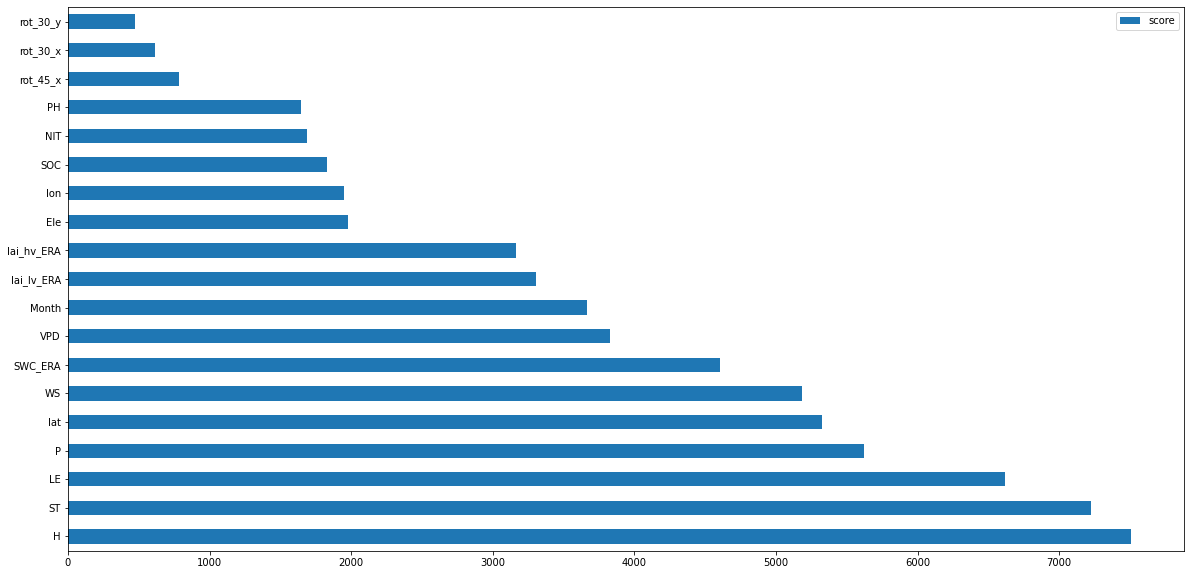

In [ ]:
# Final model -- train on all sites not separately
# train on all the data
import pickle

train_sites = sites
trainX_dataset = new_dataset.drop(columns=['Site','NEE']) # xgboost can read DF file directly
trainY_dataset = new_dataset['NEE']


test_sites = sites
testX_dataset = new_dataset.drop(columns=['Site','NEE'])
testY_dataset = new_dataset['NEE']

# train and test dataset

regressor=xgb.XGBRegressor(eval_metric='rmse')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {
              "n_estimators": [450, 500,550],
              "learning_rate": [0.01,0.02,0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=4).fit(trainX_dataset, trainY_dataset)

#print("The best hyperparameters are ",search.best_params_)
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                        n_estimators  = search.best_params_["n_estimators"],
                        max_depth     = 8,
                        eval_metric='rmse')

regressor.fit(trainX_dataset, trainY_dataset)
# pickle.dump(regressor, open('/content/drive/My Drive/NEE/XGBoost/1127/final_model/xgb_final.pkl', "wb"))

regressor.save_model('/content/drive/My Drive/NEE/XGBoost/0121/final_model/xgb_final_0121.json')

# xgb_model_loaded = pickle.load(open(file_name, "rb"))

# regressor.save_model('/content/drive/My Drive/NEE/XGBoost/old/final_model/xgb_%s.json' % num_ite)

feature_important = regressor.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

fi = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
fi.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
fi.to_csv(r'/content/drive/My Drive/NEE/XGBoost/0121/final_model/fi_final_0121.csv' )

#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================

train_predictions = regressor.predict(trainX_dataset)
predictions = regressor.predict(testX_dataset)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_dataset.values,train_predictions))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_dataset.values,predictions))
print('Test Score: %.2f RMSE' % (testScore))
# calculate correlation score
corr_train, _ = pearsonr(trainY_dataset.values,train_predictions)
print('Train corr: %.2f corr' % (corr_train))
corr_test, _ = pearsonr(testY_dataset.values,predictions)
print('Test corr: %.2f corr' % (corr_test))

In [ ]:
model2 = xgb.XGBRegressor()
model2.load_model('/content/drive/My Drive/NEE/XGBoost/0121/final_model/xgb_final_0121.json')